# Chest X-ray Classification using CNN

This project aims to classify chest X-rays as normal or abnormal using a convolutional neural network (CNN).

Dataset: NIH Chest X-ray dataset from Kaggle.

## 1. Load and Explore Dataset

In [31]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import _tf_uses_legacy_keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split

In [32]:
# Configure logging
logging.basicConfig(
    filename='training_log.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logging.info("Logging initialized successfully.")

In [33]:
# Define separate paths for labels and images
labels_path = os.path.join("data", "archive", "Data_Entry_2017.csv")  # Path for CSV file
images_path = os.path.join("data", "images")  # Path for actual images

# List files in the archive folder to verify its contents
print(os.listdir(os.path.dirname(labels_path)))

# Load the labels CSV file
logging.info(f"Loading labels from: {labels_path}")
df = pd.read_csv(labels_path)
logging.info("labels loaded successfully")

# Show first few rows of the dataset
df.head()


['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'test_list.txt', 'train_val_list.txt']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


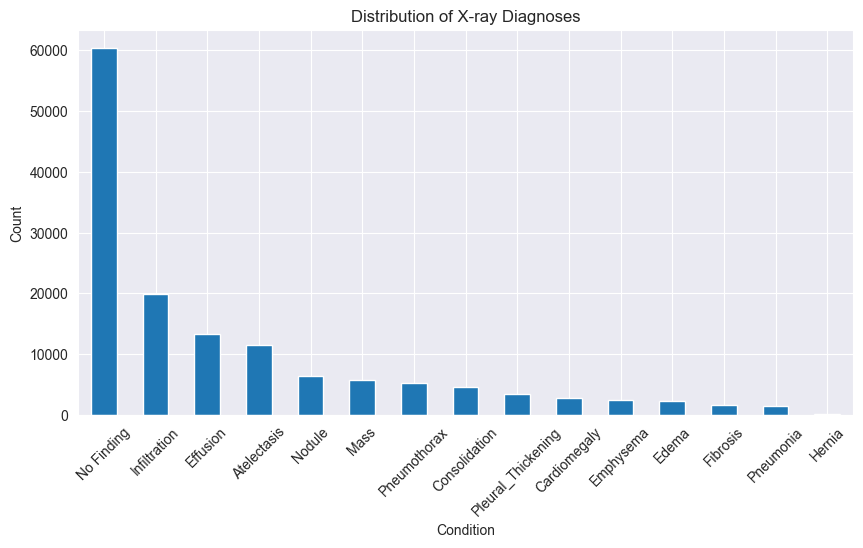

In [34]:
# Split multi-label strings into a list of individual conditions
all_conditions = df["Finding Labels"].str.split("|", expand=True).stack()

# Count occurrences of each condition
condition_counts = all_conditions.value_counts()

# Plot the cleaned-up distribution
plt.figure(figsize=(10, 5))
condition_counts.plot(kind="bar")
plt.title("Distribution of X-ray Diagnoses")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.show()
logging.info("Distribution of X-ray Diagnoses made successfully")

## 2. Data Preprocessing
Before feeding images into the CNN, we need to do the following:
- Convert grayscale X-ray images to a standard format
- Resize images to a fixed size (224x224)
- Normalize pixel values (0 to 1)
- Split dataset into Training and Testing sets

In [13]:
# Create a binary label: 0 = Normal, 1 = Abnormal
df["label"] = df["Finding Labels"].apply(lambda x: 0 if "No Finding" in x else 1)

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print(f"Training samples:  {len(train_df)}, Testing samples: {len(test_df)}")
logging.info(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

Training samples:  89696, Testing samples: 22424


In [14]:
print("Training Set Distribution:")
print(train_df["label"].value_counts())

print("\nTesting Set Distribution:")
print(test_df["label"].value_counts())


Training Set Distribution:
label
0    48289
1    41407
Name: count, dtype: int64

Testing Set Distribution:
label
0    12072
1    10352
Name: count, dtype: int64


In [37]:
IMG_SIZE = 224

def load_and_preprocess_image(img_path):
    """Load an image, convert to grayscale, resize, and normalize it."""
    if not os.path.exists(img_path):
        logging.warning(f"Warning: Image not found at {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE))  # Return a blank image to avoid crashing

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    if image is None:
        logging.warning(f"Warning: OpenCV failed to load image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE))  # Return a blank image

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to (224,224)
    image = image / 255.0  # Normalize pixel values to 0-1
    return image


In [17]:
def save_batches(df, images_path, batch_size=1000, save_dir='batches'):
    """Preprocess and save data in batches to disk."""
    os.makedirs(save_dir, exist_ok=True)
    image_paths = df["Image Index"].apply(lambda x: os.path.join(images_path, x)).values
    labels = df["label"].values

    batch_images, batch_labels = [], []
    batch_num = 0

    for i, (img_path, label) in enumerate(zip(image_paths, labels)):
        image = load_and_preprocess_image(img_path)
        if image is None:
            continue

        batch_images.append(image)
        batch_labels.append(label)

        # Save batch
        if (i + 1) % batch_size == 0 or (i + 1) == len(df):
            X = np.array(batch_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
            y = np.array(batch_labels)
            np.save(os.path.join(save_dir, f'X_batch_{batch_num}.npy'), X)
            np.save(os.path.join(save_dir, f'y_batch_{batch_num}.npy'), y)
            logging.info(f"Saved batch {batch_num}")
            batch_images, batch_labels = [], []
            batch_num += 1

In [ ]:
save_batches(train_df, images_path, batch_size=1000, save_dir='batches')

In [19]:
def load_batch(batch_num, save_dir='batches'):
    """Load preprocessed batch from disk."""
    X = np.load(os.path.join(save_dir, f'X_batch_{batch_num}.npy'), mmap_mode='r')
    y = np.load(os.path.join(save_dir, f'y_batch_{batch_num}.npy'))
    return X, y

In [27]:
def create_cnn_model(input_shape):
    """Creates and returns a CNN model."""
    model = Sequential()
    model.add(Input(shape=input_shape))  # <-- Preferred way to set input shape
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Path to established model
model_path = os.path.join("saved_models", "cnn_chest_xray_model.keras")

# Training on established model or creating new model if none exists
if os.path.exists(model_path):
    logging.info("Loading existing model...")
    model = load_model(model_path)
else:
    logging.info("No existing model found, creating new model...")
    model = create_cnn_model((224, 224, 1))

# Count number of saved batches
num_batches = len([f for f in os.listdir('batches') if f.startswith('X_batch_')])

# Set number of epochs
epochs = 5

# Training loop with progress bar
for epoch in range(epochs):
    logging.info(f"\nEpoch {epoch + 1}/{epochs}")
    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch + 1}", miniters=5)

    for batch_num in progress_bar:
        X_batch, y_batch = load_batch(batch_num)  # Your batch loading function
        history = model.fit(X_batch, y_batch, epochs=1, verbose=0)  # Train silently
        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            "loss": f"{history.history['loss'][0]:.4f}",
            "accuracy": f"{history.history['accuracy'][0]:.4f}"
        })
    logging.info(f"Epoch {epoch + 1} completed: Loss = {history.history['loss'][0]}, Accuracy = {history.history['accuracy'][0]}")

logging.info("\nTraining complete!")

In [11]:
# Save the trained model
model.save(model_path, overwrite=True)
logging.info("Model saved successfully!")

Model saved successfully!


In [ ]:
# Load the saved model
model = load_model(model_path)
logging.info("Model loaded successfully!")